# Import libraries, data

In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [2]:
snp_data = pd.read_csv('../Data/Structured_Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Helper functions to get data

function to download live data

In [47]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

function to read cached data from csv

In [48]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [80]:
readDailyReturnsFromCsv(['AAPL',])

,AAPL
Date,
2021-11-09,0.002460
2021-11-10,-0.019163
2021-11-11,-0.000338
2021-11-12,0.014337
2021-11-15,0.000067
...,...
2022-11-01,-0.017543
2022-11-02,-0.037305
2022-11-03,-0.042405


# Compile lists of relevant stocks

In [9]:
snp_data[:10]

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,396,557,976,700",0.60%,21.67,6.21,32.78,Analyze
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$1,700,887,137,266",1.08%,22.04,8.83,9.80,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.82,4.04,2.00,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.69,4.04,1.96,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$987,418,107,695",0.00%,42.54,2.07,6.80,Analyze
5,TSLA,Tesla Inc,Common stocks,Large cap,Consumer Discretionary,"$713,867,145,652",0.00%,80.33,11.48,19.79,Analyze
6,BRK.B,Berkshire Hathaway Inc. Class B,Common stocks,Large cap,Financials,"$648,469,030,904",0.00%,4.42,1.83,0.71,Analyze
7,UNH,Unitedhealth Group Inc,Common stocks,Large cap,Health Care,"$511,944,311,010",1.13%,29.14,1.73,6.99,Analyze
8,XOM,Exxon Mobil Corp,Common stocks,Large cap,Energy,"$466,400,177,773",3.10%,17.95,1.52,2.74,Analyze
9,JNJ,Johnson & Johnson,Common stocks,Large cap,Health Care,"$452,540,967,536",2.51%,22.51,4.77,5.97,Analyze


Some of the top tech stocks like Google are classified as "Communication Services", so we include those

In [27]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]

In [93]:
print(top20_it_comm_stocks)

['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA', 'QCOM']


# Rolling Ridge Regression Model (without Sentiment)

## Define function for Rolling Regression model (without sentiment)

In [91]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

# tickers_as_predictors -> IF liveData=False, use [filename1, filename2] if using cached data e.g. [']
# otherwise feed [predictorTicker1, predictorTicker] e.g. ['AMZN', 'AMD', 'NVDA']
def Model(tickers_to_predict=['AAPL', 'TSLA', 'META'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        window = 120, lookback = 30, thresh = 1, 
        intercept = False, fullReport = False, liveData = False, trainPeriod='1y'):
    retsSpreads = []
    for tick in tickers_to_predict:
        # if live data wanted
        if liveData:
            Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], trainPeriod)
            yhist = makeDailyReturnsDf([tick],trainPeriod)
        # read from csv file instead of pulling live data to match the sentiment predictions by Elton
        else:
            yhist = readDailyReturnsFromCsv([tick])
            yhist.index = pd.to_datetime(yhist.index, utc=True).date
            yhist.index.rename('Date', inplace=True)

            # returns data
            Xhist = readDailyReturnsFromCsv(tickers_as_predictors)
            if tick in Xhist.columns:
                Xhist.drop(columns=tick, inplace=True)
            Xhist.index = pd.to_datetime(Xhist.index, utc=True).date
            Xhist.index.rename('Date', inplace=True)     
        
        Xyhist = pd.concat([Xhist, yhist], axis=1)

        # get betas
        if intercept:
            ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
        else:
            ols = RollingOLS(yhist, Xhist, window=window).fit()
        betas = ols.params.dropna()
        # get portfolio weights
        if intercept:
            spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            spread = yhist[tick] - (betas * (Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        # print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)
    if fullReport:
        qs.reports.full(retsSpreads.mean(1), rf=0.02)
    else:
        print(sharpe)
    return sharpe
# , benchmark='SPY', match_dates=True)

## Running the Model

when running with liveData=True, feed to tickers_as_predictors a list of stock tickers

In [86]:
print(top20_it_comm_stocks)

['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA', 'QCOM']


In [84]:
Model(['AAPL'], tickers_as_predictors=top20_it_comm_stocks, liveData=True)

0.143


0.143

when running with liveData=False, feed to tickers_as_predictors a list of the filenames that contain the predictors -- NOTE: exclude '.csv' from the filename

In [85]:
Model(['AAPL'], tickers_as_predictors=['top20_it_comm_stocks'], liveData=False)

0.815


0.815

scores are different because the model has taken new data

## Grid Search on Model without Sentiment

In [92]:
import itertools
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path = []
best_params = tuple()
best_Sharpe = 0

for params in itertools.product(tickers_sets_to_predict, windows, z_lookbacks, thresh, intercepts):
    ts, w, z, t, i = params
    sharpe = Model(tickers_to_predict=ts, window=w, lookback=z, thresh=t, intercept=i)
    # performance = list(params)
    # using tuples makes it hashable -> can groupby and find max Sharpe
    performance = list((tuple(ts), w, z, t, i))
    performance.append(sharpe)
    search_path.append(performance)

    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
        print('new best Sharpe ratio found!',best_Sharpe)
        print('new best params', best_params)
    

-0.609
-0.76
-1.407
-1.352
-1.007
-1.147
-1.409
-1.406
-0.533
-0.316
-1.213
-1.153
-1.241
-1.221
-1.457
-1.455
-0.993
-0.994
-1.308
-1.043
-1.303
-1.273
-1.365
-1.363
0.197
new best Sharpe ratio found! 0.197
new best params (['AAPL', 'TSLA', 'META'], 120, 15, 0.75, False)
-0.188
-0.293
-0.29
-0.92
-0.755
-1.114
-1.068
0.178
-0.205
-0.447
-0.319
-0.831
-0.822
-1.073
-1.068
0.258
new best Sharpe ratio found! 0.258
new best params (['AAPL', 'TSLA', 'META'], 120, 45, 0.75, False)
-0.013
-0.501
-0.5
-0.85
-0.841
-1.1
-1.238
1.218
new best Sharpe ratio found! 1.218
new best params (['AAPL', 'TSLA', 'META'], 150, 15, 0.75, False)
1.336
new best Sharpe ratio found! 1.336
new best params (['AAPL', 'TSLA', 'META'], 150, 15, 0.75, True)
0.862
0.533
-0.082
-0.09
-0.187
-0.197
1.062
1.057
0.23
0.242
0.124
0.115
-0.505
-0.509
0.864
0.865
-0.15
-0.321
0.061
0.051
-0.616
-0.617
-0.324
-0.564
-1.66
-1.57
-1.296
-1.522
-1.815
-1.808
-0.383
-0.069
-1.575
-1.461
-1.708
-1.612
-1.9
-1.892
-1.042
-1.246
-1.

In [94]:
print(best_Sharpe)
print(best_params)

2.091
(['AAPL'], 150, 30, 0.75, True)


see top scoring combinations

In [96]:
search_path_df = pd.DataFrame(search_path, columns=['tickers_to_predict', 'window', 'lookback', 'thresh', 'intercept', 'Sharpe_ratio'])
search_path_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
search_path_df.head()

,tickers_to_predict,window,lookback,thresh,intercept,Sharpe_ratio
345,"(AAPL,)",150,30,0.75,True,2.091
344,"(AAPL,)",150,30,0.75,False,2.076
339,"(AAPL,)",150,15,1.00,True,2.067
353,"(AAPL,)",150,45,0.75,True,2.067
337,"(AAPL,)",150,15,0.75,True,2.063


see top Sharpe ratio by set of tickers to predict (WITH NO SENTIMENT)

In [97]:
search_path_df.groupby('tickers_to_predict').max('Sharpe_ratio')

,window,lookback,thresh,intercept,Sharpe_ratio
tickers_to_predict,,,,,
"(AAPL,)",150,45,2.0,True,2.091
"(AAPL, TSLA, META)",150,45,2.0,True,1.336
"(META,)",150,45,2.0,True,0.410
"(META, TSLA)",150,45,2.0,True,0.524
"(TSLA,)",150,45,2.0,True,0.567


In [99]:
search_path_df.to_csv('linear_reg_wo-sent_search.csv', index=False)

# Rolling Ridge Regression Model (with Sentiment)

cache data because we want to make sure that we have enough overlaps on dates with the static sentiment data

In [13]:
# top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks, '1y')
# top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')
# top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
# top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [14]:
# AAPL = makeDailyReturnsDf(['AAPL'], '1y')
# AAPL.to_csv('../Data/Structured_Data/AAPL.csv')
# TSLA = makeDailyReturnsDf(['TSLA'], '1y')
# TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
# META = makeDailyReturnsDf(['META'], '1y')
# META.to_csv('../Data/Structured_Data/META.csv')

## Define Function for Sentiment Model

In [45]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

# tickers_as_predictors -> use [filename] if using cached data (i.e. liveData=False), 
# otherwise feed [predictorTicker1, predictorTicker]
def ModelwSentiment(tickers_to_predict=['AAPL', 'TSLA', 'META'], 
        tickers_as_predictors=['top20_it_comm_stocks'],
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', 
        sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, 
        intercept = False, fullReport = False, liveData = False, trainPeriod='1y'):
    retsSpreads = []
    for tick in tickers_to_predict:
        if liveData:
            Xhist_rets = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], trainPeriod)
            Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
            Xhist_rets.index.rename('Date', inplace=True)
            yhist = makeDailyReturnsDf([tick], trainPeriod)
            yhist.index = pd.to_datetime(yhist.index, utc=True).date
            yhist.index.rename('Date', inplace=True)
        else:
            # read from csv file instead of pulling live data to match the sentiment predictions by Elton
            yhist = readDailyReturnsFromCsv([tick])
            yhist.index = pd.to_datetime(yhist.index, utc=True).date
            yhist.index.rename('Date', inplace=True)

            # returns data
            Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
            if tick in Xhist_rets.columns:
                Xhist_rets.drop(columns=tick, inplace=True)
            Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
            Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data -> is never live, so put outside loop
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # get betas
        if intercept:
            ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
        else:
            #TODO: add sentiment here
            ols = RollingOLS(yhist, Xhist, window=window).fit()
        betas = ols.params.dropna()
        # get portfolio weights
        if intercept:
            spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            #TODO: add sentiment here
            # spread is the residuals
            spread = yhist[tick] - (betas * (Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        # print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        if tick in betas.columns:
            betas = betas.drop(columns=tick, inplace=False)
        if tick in weights.columns:
            weights.drop(columns=tick, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)
    if fullReport:
        qs.reports.full(retsSpreads.mean(1), rf=0.02)
    else:
        print(sharpe)
    return sharpe
# , benchmark='SPY', match_dates=True)

## Running the Model with Sentiment

when running with liveData=True, use predefined list of stock tickers

In [87]:
print(top20_it_comm_stocks)

['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA', 'QCOM']


In [72]:
ModelwSentiment(tickers_to_predict=['META', 'TSLA', 'AAPL'], 
        tickers_as_predictors=top20_it_comm_stocks, 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned', sentiment_file = '/stacked_pred_returns_rfr_test.csv', 
        window = 120, lookback = 15, thresh = 1, intercept = False, liveData=True)

0.882


0.882

when running with liveData=False, feed to tickers_as_predictors a list of the filenames that contain the predictors -- NOTE: exclude '.csv' from the filename

In [81]:
ModelwSentiment(tickers_to_predict=['META', 'TSLA', 'AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned', sentiment_file = '/stacked_pred_returns_rfr_test.csv', 
        window = 120, lookback = 15, thresh = 1, intercept = False, liveData=False)

0.882


0.882

scores are the same because the model is limited to dates where there is sentiment available

## Grid Search on Model with Sentiment

In [49]:
import itertools
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
sentiment_files = ['/finbert_pred_returns_rfr_test.csv', '/flair_pred_returns_rfr_test.csv', '/stacked_pred_returns_rfr_test.csv', '/vader_pred_returns_rfr_test.csv']
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path_sent = []
best_params = tuple()
best_Sharpe = 0

for params in itertools.product(tickers_sets_to_predict, sentiment_files, windows, z_lookbacks, thresh, intercepts):
    ts, s, w, z, t, i = params
    sharpe = ModelwSentiment(tickers_to_predict=ts, sentiment_filepath='../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned', sentiment_file=s, window=w, lookback=z, thresh=t, intercept=i)
    # performance = list(params)
    # using tuples makes it hashable -> can groupby and find max Sharpe
    performance = list((tuple(ts), s, w, z, t, i))
    performance.append(sharpe)
    search_path_sent.append(performance)

    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
        print('new best Sharpe ratio found!',best_Sharpe)
        print('new best params', best_params)
    

-1.092
-1.085
-1.145
-0.989
-0.871
-0.9
-1.304
-1.312
-0.965
-1.011
-0.622
-0.599
-1.087
-1.092
-1.277
-1.287
-0.981
-1.015
-1.133
-0.934
-1.159
-1.169
-1.277
-1.287
0.804
new best Sharpe ratio found! 0.804
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
1.842
new best Sharpe ratio found! 1.842
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
1.854
new best Sharpe ratio found! 1.854
new best params (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
1.787
0.788
0.778
0.668
0.651
1.652
1.766
0.934
0.944
0.914
0.909
0.668
0.651
1.513
1.788
0.892
0.885
0.668
0.651
0.668
0.651
-3.012
-2.973
-2.914
-2.636
-3.097
-3.119
-3.097
-3.119
-3.677
-3.645
-2.626
-2.636
-3.097
-3.119
-3.097
-3.119
-4.245
-4.232
-2.626
-2.636
-3.097
-3.119
-3.097
-3.119
-1.338
-1.078
-1.284
-1.032
-1.123
-1.099
-1.389
-1.361
-0.97
-0.793
-0.942
-1.07
-1.36
-1.334
-1.389
-1.361
-0.

In [50]:
best_Sharpe

3.566

In [51]:
best_params

(['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)

In [52]:
search_path_sent_df = pd.DataFrame(search_path_sent, columns=['tickers_to_predict', 'sentiment_filepath', 'window', 'lookback', 'thresh', 'intercept', 'Sharpe_ratio'])
search_path_sent_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
search_path_sent_df.head()

,tickers_to_predict,sentiment_filepath,window,lookback,thresh,intercept,Sharpe_ratio
681,"(META,)",/flair_pred_returns_rfr_test.csv,120,30,0.75,True,3.566
320,"(META, TSLA)",/finbert_pred_returns_rfr_test.csv,120,30,0.75,False,3.397
393,"(META, TSLA)",/flair_pred_returns_rfr_test.csv,120,30,0.75,True,3.283
321,"(META, TSLA)",/finbert_pred_returns_rfr_test.csv,120,30,0.75,True,3.272
674,"(META,)",/flair_pred_returns_rfr_test.csv,120,15,1.00,False,3.252


see top Sharpe ratio by set of tickers to predict (WITH SENTIMENT)

In [53]:
search_path_sent_df.groupby('tickers_to_predict').max('Sharpe_ratio')

,window,lookback,thresh,intercept,Sharpe_ratio
tickers_to_predict,,,,,
"(AAPL,)",150,45,2.0,True,0.439
"(AAPL, TSLA, META)",150,45,2.0,True,1.981
"(META,)",150,45,2.0,True,3.566
"(META, TSLA)",150,45,2.0,True,3.397
"(TSLA,)",150,45,2.0,True,2.199


In [66]:
search_path_sent_df[search_path_sent_df['Sharpe_ratio'].isin(search_path_sent_df.groupby('tickers_to_predict').max('Sharpe_ratio')['Sharpe_ratio'])]

,tickers_to_predict,sentiment_filepath,window,lookback,thresh,intercept,Sharpe_ratio
681,"(META,)",/flair_pred_returns_rfr_test.csv,120,30,0.75,True,3.566
320,"(META, TSLA)",/finbert_pred_returns_rfr_test.csv,120,30,0.75,False,3.397
968,"(TSLA,)",/flair_pred_returns_rfr_test.csv,120,30,0.75,False,2.199
1049,"(TSLA,)",/stacked_pred_returns_rfr_test.csv,120,45,0.75,True,1.981
1035,"(TSLA,)",/stacked_pred_returns_rfr_test.csv,120,15,1.00,True,1.981
1043,"(TSLA,)",/stacked_pred_returns_rfr_test.csv,120,30,1.00,True,1.981
242,"(AAPL, TSLA, META)",/vader_pred_returns_rfr_test.csv,120,15,1.00,False,1.981
1051,"(TSLA,)",/stacked_pred_returns_rfr_test.csv,120,45,1.00,True,1.981
1258,"(AAPL,)",/flair_pred_returns_rfr_test.csv,120,30,1.00,False,0.439


In [22]:
search_path_sent_df.to_csv('linear_reg_search3.csv', index=False)

Run Model on best parameters, print full report

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.33%
CAGR﹪                     11.69%

Sharpe                     1.98
Prob. Sharpe Ratio         83.7%
Smart Sharpe               1.87
Sortino                    3.41
Smart Sortino              3.22
Sortino/√2                 2.41
Smart Sortino/√2           2.28
Omega                      1.39

Max Drawdown               -1.16%
Longest DD Days            15
Volatility (ann.)          4.58%
Calmar                     10.09
Skew                       0.36
Kurtosis                   0.08

Expected Daily %           0.04%
Expected Monthly %         0.77%
Expected Yearly %          2.33%
Kelly Criterion            15.95%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.43%
Expected Shortfall (cVaR)  -0.43%

Max Consecutive Wins       4
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-1.158618,-1.004337
2,2022-07-22,2022-07-26,2022-07-29,7,-1.132456,-0.781097
3,2022-06-27,2022-07-01,2022-07-07,10,-0.699727,-0.659769
4,2022-07-08,2022-07-12,2022-07-19,11,-0.572241,-0.413936
5,2022-08-04,2022-08-09,2022-08-10,6,-0.353643,-0.164131


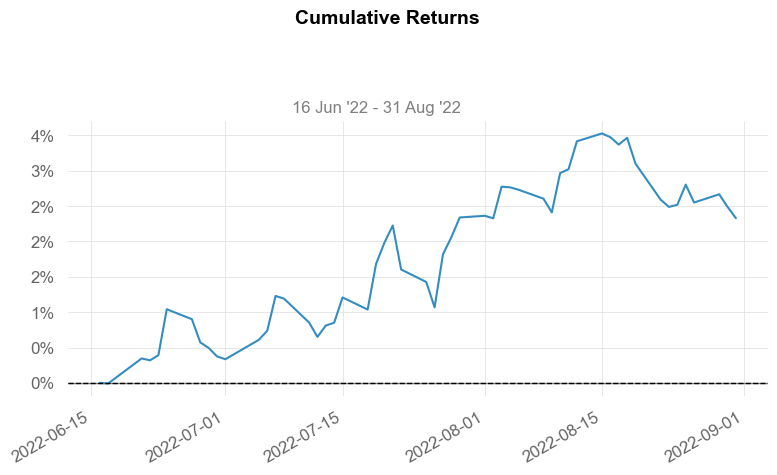

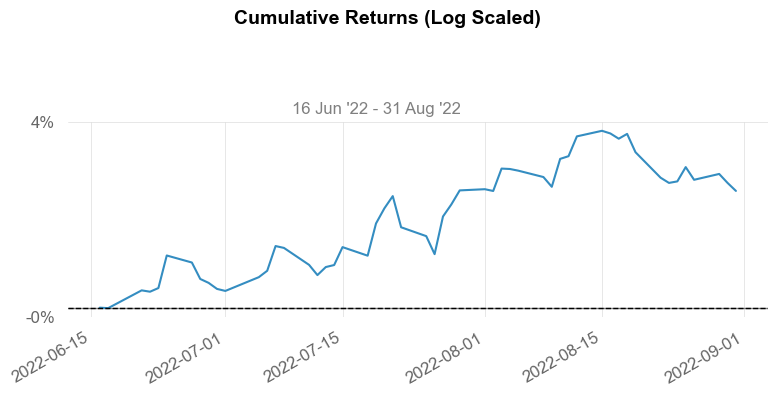

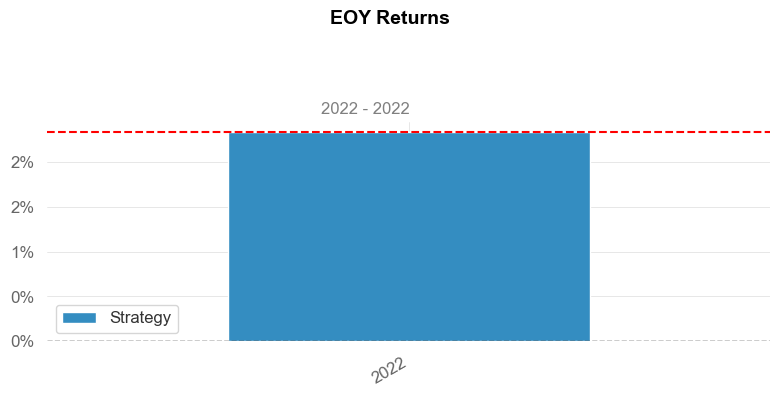

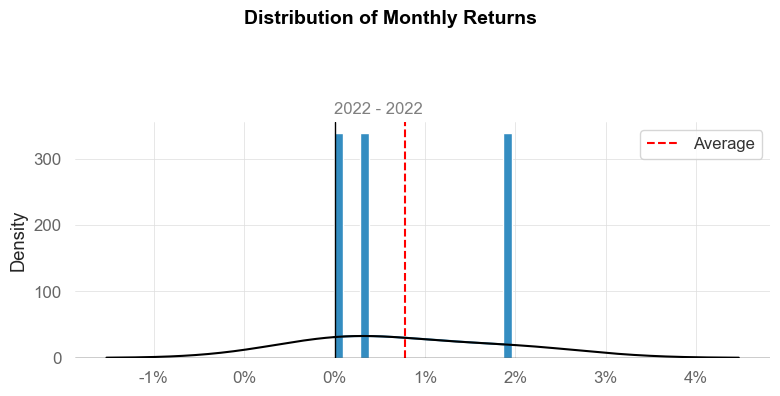

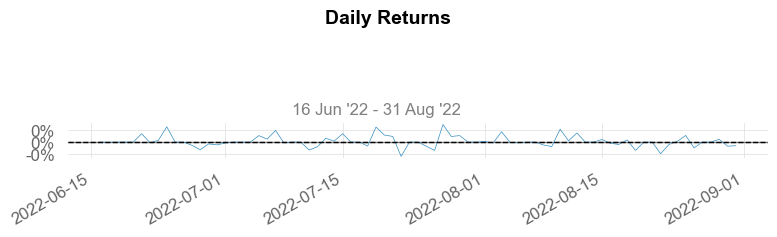

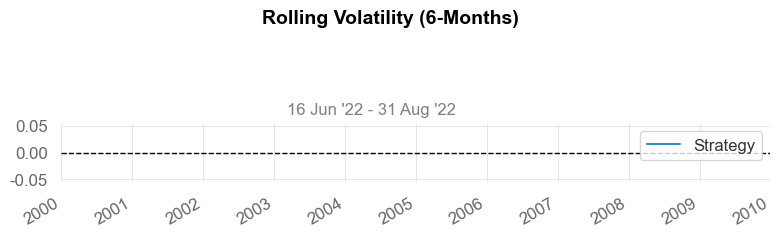

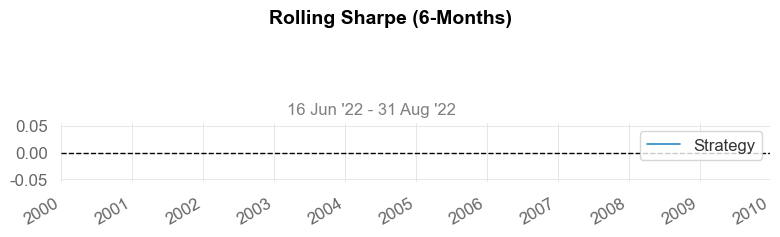

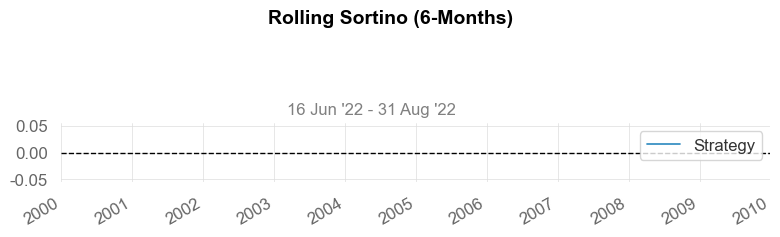

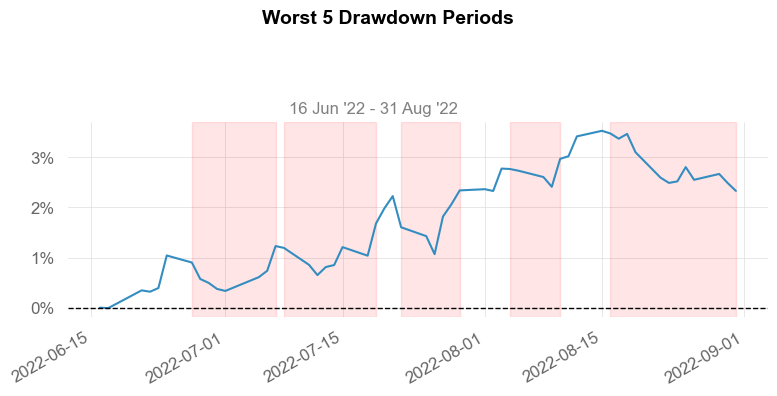

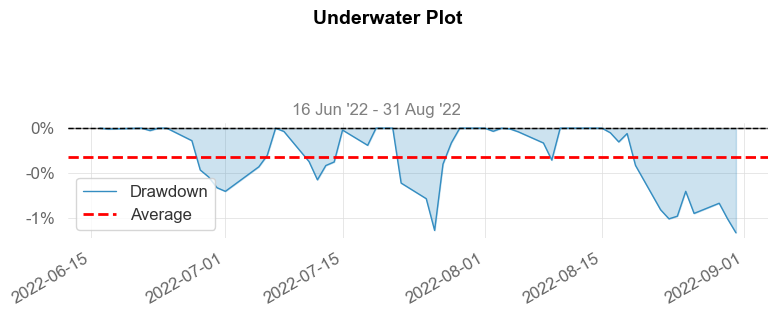

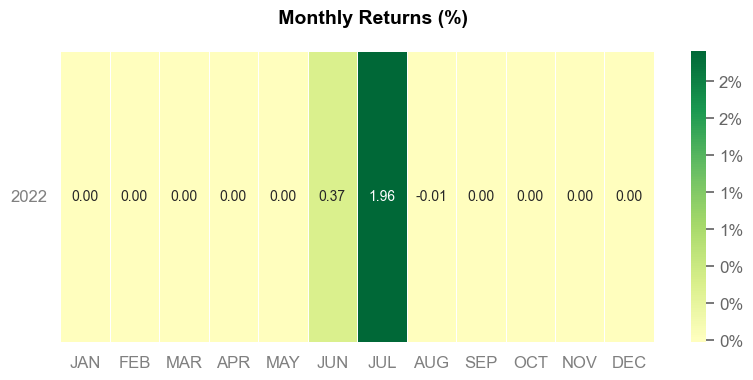

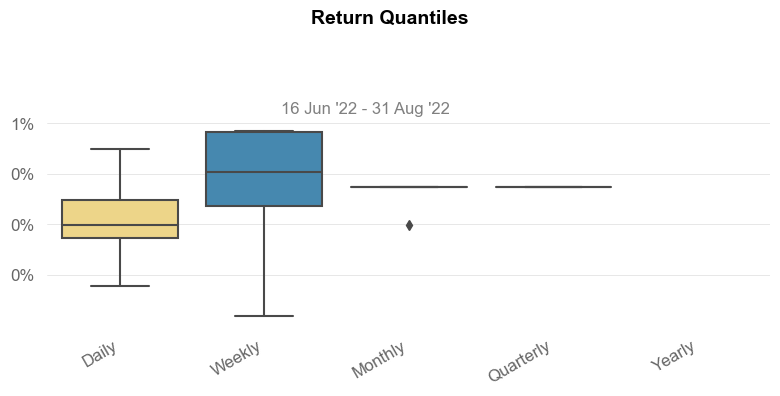

1.981

In [65]:
# best params for joint model: # "('AAPL', 'TSLA', 'META')",/vader_pred_returns_rfr_test.csv,120,15,1.0,False,1.981
ModelwSentiment(tickers_to_predict=['AAPL', 'TSLA', 'META'], sentiment_filepath='../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned', 
sentiment_file='/vader_pred_returns_rfr_test.csv', window=120, lookback=15, thresh=1.0, intercept=False, fullReport=True)

# Baseline model

Take the date range for which we have data

In [38]:
sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/Tuned'
sentiment_file = '/finbert_pred_returns_rfr_test.csv'
daterange = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0).index
start = daterange.min()
end = daterange.max()
print(start)
print(end)

2021-12-24
2022-08-31


Simulate buying and holding by taking average of returns

In [40]:
baseline = []
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]
for tset in tickers_sets_to_predict:
    rets_df = makeDailyReturnsDf(tset, '2y')
    sharpe = round(qs.stats.sharpe(rets_df[start:end].mean(1), rf=0.02),3)
    performance = (tuple(tset), sharpe)
    baseline.append(performance)
    print(tset, sharpe)


['AAPL', 'TSLA', 'META'] -0.843
['META', 'TSLA'] -0.94
['META'] -1.393
['TSLA'] -0.255
['AAPL'] -0.377


In [41]:
baseline_df = pd.DataFrame(baseline, columns=['buy_and_hold_tickers', 'Sharpe_ratio'])
baseline_df.sort_values(by='Sharpe_ratio', ascending=False, inplace=True)
baseline_df

,buy_and_hold_tickers,Sharpe_ratio
3,"(TSLA,)",-0.255
4,"(AAPL,)",-0.377
0,"(AAPL, TSLA, META)",-0.843
1,"(META, TSLA)",-0.940
2,"(META,)",-1.393


# Compare Performance with Raw Sentiment Model

In [108]:
sent_baseline = []
sent_sets_to_predict = ['finbert_pred_returns_rfr_test.csv', 'flair_pred_returns_rfr_test.csv', 'stacked_pred_returns_rfr_test.csv', 'vader_pred_returns_rfr_test.csv']

for sent_pred in sent_sets_to_predict:
    retsSpreads = []
    weights = pd.read_csv('../Data/3_Predictions/Unstructured_Data/rf_regressor/returns/'+sent_pred, index_col=0)
    start = weights.index.min()
    end = weights.index.max()

    Xyhist = makeDailyReturnsDf(['AAPL', 'META', 'TSLA'])
    Xyhist = Xyhist[start:end]

    retsSpreads.append((weights.shift(1) * 
                        Xyhist.reindex(weights.index).dropna()).sum(1))

    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(weights.index).dropna().reset_index()

    sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)

    sent_baseline.append((sent_pred,sharpe))
    print(sent_pred, sharpe)
    # return sharpe

/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2954/1965280761.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)


finbert_pred_returns_rfr_test.csv -1.604


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2954/1965280761.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)


flair_pred_returns_rfr_test.csv -3.646


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2954/1965280761.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)


stacked_pred_returns_rfr_test.csv -4.345
vader_pred_returns_rfr_test.csv -2.827


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2954/1965280761.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe = round(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02),3)


In [109]:
sent_baseline_df = pd.DataFrame(sent_baseline, columns=['sent_pred','Sharpe_ratio'])

In [110]:
sent_baseline_df

,sent_pred,Sharpe_ratio
0,finbert_pred_returns_rfr_test.csv,-1.604
1,flair_pred_returns_rfr_test.csv,-3.646
2,stacked_pred_returns_rfr_test.csv,-4.345
3,vader_pred_returns_rfr_test.csv,-2.827
